introduire présentation et mettre une image de l'objectif



# MNIST data set

We use fast.ai to download the MNIST data set

In [ ]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [ ]:
from fastai.vision.all import *
from fastbook import *

In [ ]:
path = untar_data(URLs.MNIST_SAMPLE)

We downloaded a sample selected by Fast.ai of the MNIST data containing only threes and sevens. let's look at what is inside

In [ ]:
path.ls()

(#3) [Path('/root/.fastai/data/mnist_sample/valid'),Path('/root/.fastai/data/mnist_sample/train'),Path('/root/.fastai/data/mnist_sample/labels.csv')]

Let's clean it a bit :

In [ ]:
Path.BASE_PATH = path

In [ ]:
path.ls()

(#3) [Path('valid'),Path('train'),Path('labels.csv')]

In [ ]:
(path/'train').ls()

(#2) [Path('train/7'),Path('train/3')]

# Data Preprocessing : preparing test and validation dataset

We put the training data into variables : 

In [ ]:
threes = (path/'train/3').ls()
sevens = (path/'train/7').ls()
sevens

(#6265) [Path('train/7/33681.png'),Path('train/7/40214.png'),Path('train/7/3788.png'),Path('train/7/42544.png'),Path('train/7/47325.png'),Path('train/7/6147.png'),Path('train/7/617.png'),Path('train/7/51138.png'),Path('train/7/56567.png'),Path('train/7/37835.png')...]

And put all the images into tensors so that we can use is in our model. To do so we use list comprehension : 

In [ ]:
train_three_tensors = [tensor(Image.open(o)) for o in threes]
train_seven_tensors = [tensor(Image.open(o)) for o in sevens]
print(len(train_seven_tensors))
train_seven_tensors[0]

6265


tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  

We regroup all the tensors of our lists into two tensors of rank 3

In [ ]:
train_threes = torch.stack(train_three_tensors).float()/255 #the data type was uint8 which is not comptatible with matrice multiplication (we need it later)
train_sevens = torch.stack(train_seven_tensors).float()/255
train_sevens.shape

torch.Size([6265, 28, 28])

Now we repeat the same steps for our validation dataset.

In [ ]:
valid_threes = torch.stack([tensor(Image.open(o)) for o in (path/"valid/3").ls()]).float()/255
valid_sevens = torch.stack([tensor(Image.open(o)) for o in (path/"valid/7").ls()]).float()/255

len(valid_sevens)

1028

Now we will concatenate the sevens and threes tensors into a training and a validation tensors. We will call them train_x and valid_x. The "x" means the rank 2 tensors are the dependent variable of our model (the variable on which our model will train to predict the independant variable or label, which is commonly written as "y") 

In [ ]:
train_x = torch.cat([train_threes,train_sevens])
valid_x = torch.cat([valid_threes,valid_sevens])

Now we create the label of our data. We label all the threes by 1 and all the sevens by 0.

In [ ]:
train_y = tensor([1]*len(train_threes)+[0]*len(train_sevens))
valid_y = tensor ([1]*len(valid_threes)+ [0]*len(valid_sevens))

In [ ]:
train_x.shape, train_y.shape

(torch.Size([12396, 28, 28]), torch.Size([12396]))

We now have a problem. we want to make a list of tuple (x,y) but the shape of train_x and train_y are too different. 

To solve this problem we will transform the 28 by 28 matrices into long vectors of 784 elements and transform our label vector into a matrice of 12396 rows and 1 column.

In [ ]:
train_x = train_x.view(12396,-1) # we could have written (12396,784) or (12396,28*28), but -1 is easier.
#It means, make this dimension as big as it should be to fit all the remaining data
#That's why we could have also writen (-1, 28*28)
train_y = train_y.view(-1,1)
train_x.shape, train_y.shape

(torch.Size([12396, 784]), torch.Size([12396, 1]))

We do the same transformation for the validation set

In [ ]:
valid_x = valid_x.view(-1,28*28)
valid_y = valid_y.view(-1,1)

valid_x.shape, valid_y.shape

(torch.Size([2038, 784]), torch.Size([2038, 1]))

Now we create our lists of tuples : 

In [ ]:
train_dataset = list(zip(train_x,train_y))
valid_dataset = list(zip(valid_x,valid_y))

And with that we can create Dataloaders : 

In [ ]:
train_dl = DataLoader(train_dataset, batch_size=100, Shuffle=True)
valid_dl = DataLoader(valid_dataset, batch_size=100, Shuffle=True)

Dataloaders creates batches of data form the tuples. The bigger the batches the more accurate the gradient is but also the longer it is to calculate. Without those batches we would train on all the data each time. 

Here is what those batches looks like : 


In [ ]:
i = 0
for xb,yb in train_dl : 
  print(xb)
  print(yb)
  i+=1
  if i>3 : 
    break

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
tensor([[1],
        [1],
        [1]])
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
tensor([[1],
        [1],
        [1]])
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
tensor([[1],
        [1],
        [1]])
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
tensor([[1],
        [1],
        [1]])


# Initialization


We now have our training and validation dataset. Next we have to initialize some weights and parameters for our model.

We will create a function that will initialize the weights randomly with a normal distribution.

In [ ]:
def param_init (size) :
  return (torch.randn(size)/100).requires_grad_() #I divided by 100 because I was saturating at the first epoch
  #It really changed everything ! The weight initialisation is really important and depends on the loss function we use (and on the architecture I suppose)
  #I also had to reduce the learning rate which was also causing the saturation

".requires_grad_()" tells Pytorch that it will have to work out the gradient of those parameters

For now our model has no hidden layers so we only need one weight for each pixel

In [ ]:
weights = param_init((784,1))
weights[0:5]

tensor([[-0.0006],
        [-0.0032],
        [ 0.0052],
        [ 0.0035],
        [-0.0154]], grad_fn=<SliceBackward>)

Now we initialize our bias : 

In [ ]:
bias = param_init(1)

# A simple linear function

Now we will create our linear function : 

In [ ]:
def linear(data) : 
  return data@weights + bias # @ does matrix multiplication.
  #The data type of our training set is uint8 which is not supported by matrix multiplication so we must convert it to float 

In [ ]:
linear(train_x)

tensor([[-0.1751],
        [-0.1815],
        [-0.0313],
        ...,
        [-0.0270],
        [-0.1397],
        [ 0.0701]], grad_fn=<AddBackward0>)

In [ ]:
i = 0
for xb,yb in train_dl : 
  #print(linear(xb),yb)  #it makes more sense when the batch size is around 5
  i+=1
  if i>3 : 
    break

# Output function : sigmoid for a classification problem

In [ ]:
def sigmoid(x): return 1/(1+torch.exp(-x))

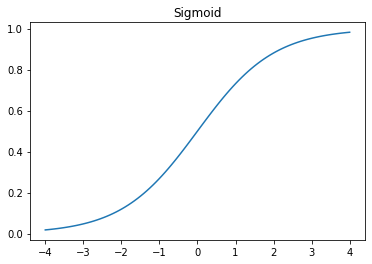

In [ ]:
plot_function(torch.sigmoid, title='Sigmoid', min=-4, max=4)

# Loss

In [ ]:
def mnist_loss1(predictions, targets):
    predictions = predictions.sigmoid()
    return torch.where(targets==1, 1-predictions, predictions).mean() # return 1-pred if target=1 (meaning it is a 3) and pred if not (it is a seven)

This loss function could do the job quite well. However we will use the Corss-Entropy loss function. Indeeed it is the most common loss function in classification problem and so if we want to know how to implement a neural network from scratch it makes sense to use it. 

It is good to know that Cross-Entropy is the most used loss function but is even better to understand why. The answer lies in the logarithme function.

In [ ]:
def log(x) : return -torch.log(x)

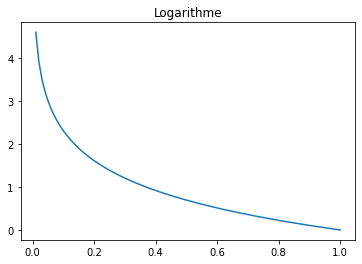

In [ ]:
plot_function(log, title='Logarithme', min=0, max=1,)

We want to use the logarithme function because the sigmoid function saturate our neural network. It means that there will be little difference after the output function if the hidden layer were quite sure or almost absolutely sure of its prediction (the input of our output function will be a really high or really low number if the hidden layer are extremely sure of their prediction). 

Now we must ask ourself the aim of our classification. If we use accuracy as our metric, being quite sure or extremely sure of a good answer has no real importance and so we don't need our NN to update the most rapidly on this part. However we want our NN to update rapidly if it predict the wrong answer and the more wrong it is the faster we want to update it. 

To update our NN we use the gradient. So the stipper the slope the faster the update is. That is why the logatihme function is so usefull, we will use its first part to focus the update of our NN on the wrong answers. To benefits from these advantages of the logarithme function on our classification problems we use the Cross-Entropy loss function

PS : we use -log(x) because we want the output to be positive. Moreover I personally find it more graphic as we could imagine the prediction of the output function as a ball dropped on our loss function and rolling down the cliff during the update of the weights. 


In [ ]:
def cross_entropy(predictions,targets, epsilon = 0, penalty = 0.01) : #epsilon is here to prevent the divergence
  return -(targets*torch.log(predictions+epsilon) + (1-targets)*torch.log(1-predictions+epsilon)) #+ penalty*sum(weights) 
  #the penalty makes the gradient way too long too calculate

In [ ]:
def mnist_loss2(predictions,targets) : 
  predictions = predictions.sigmoid() #.min(tensor([0.999999])).max(tensor([.000001])) #I have too much saturation. Beyond those limits I have 0 and 1 output 
  list1 = [cross_entropy(x,y) for (x,y) in zip(predictions,targets)]
  #I imagine that there is a way to calculate the cross-entropy of each elements of a batch without using loops but I don't know it yet. 
  #return tensor(sum(list1)/len(list1))
  return torch.stack(list1).mean()

We can use it because the output of our sigmoid function is included in ]0,1[
"label" and "(1-label)" has the same use as the target==1 condition in our loss function. ! HOWEVER if the initialization is wrongly handled and the ouput of the sigmoid is too close to 0 or 1 it will be rounded to 0 or 1 causing an error.

-log(x) will make the prediction update toward 1 (as we can see with the direction of the slope) and -log(1-x) will make the prediction update toward 0. All in all the Cross-entropy makes the predictions update toward the right target. 

We can test our loss function on the first 4 batch of our data loader. As you can see our loss without any training is quite horrible : 

In [ ]:
i = 0
#aa= 0
for xb,yb in train_dl : 
  a = mnist_loss2(linear(xb),yb)
  #aa+=a
  print(a)
  i+=1
  if i>2 : 
    break
#print(aa/i)

tensor(0.7425, grad_fn=<MeanBackward0>)
tensor(0.7406, grad_fn=<MeanBackward0>)
tensor(0.7378, grad_fn=<MeanBackward0>)


# Gradient

Now that we have our (huge) loss we can work on reducing it thanks to the gradient. To calculate our gradient we just have to call backard on our loss function. We will have the gradiant of the variables at the end of which we put ".requires_grad_()" during our initialization : our weights and bias. 

In [ ]:
def calc_grad(xb, yb, model):
    preds = model(xb)
    loss = mnist_loss2(preds, yb)
    loss.backward()
    return loss

In [ ]:
i = 0
for xb,yb in train_dl : 
  a = calc_grad(xb, yb, linear)
  #print(a)
  print(weights.grad.mean(), bias.grad)
  i+=1
  #print(yb[0])
  if i>2 : 
    break

tensor(-0.0713) tensor([-0.5238])
tensor(-0.1445) tensor([-1.0467])
tensor(-0.2192) tensor([-1.5682])


# Training

Now we will use the gradient to update our parameters.

In [ ]:
def train_epoch(dl, model, lr, params):
  tot_loss = []
  for xb,yb in dl:
    a =calc_grad(xb, yb, model)
    #print(weights.grad.mean(), bias.grad)
    #print(a)
    tot_loss.append(a)
    for p in params:
      p.data -= p.grad*lr #the attribute data tells Pytorch to not take this step into consideration while calculating the gradient
      p.grad.zero_() #each time we do loss.backward we add the gradient to the existing gradient of the variable. Thaht's why we must put the gradient to 0
  return torch.stack(tot_loss).mean().item() #item() remove the tensor sign

In [ ]:
lr = 0.001
params = weights, bias #it will be easier when we will change the number of layers

In [ ]:
train_epoch(train_dl, linear, lr, params)

0.5686315298080444

In [ ]:
for i in range(20):
    print(train_epoch(train_dl, linear, lr, params))

0.4658467769622803
0.3928288519382477
0.3407185673713684
0.3027758300304413
0.27425774931907654
0.25213998556137085
0.23450878262519836
0.22012470662593842
0.2081591784954071
0.19804082810878754
0.18936432898044586
0.1818346381187439
0.17523208260536194
0.16939006745815277
0.16417963802814484
0.15949970483779907
0.1552698165178299
0.15142527222633362
0.1479130983352661
0.1446898728609085


We did it ! Our model has learned. However the loss is not what we will use at the end to evaluate our model. To do so we will use the accuracy as the metric of our model. 

In [ ]:
sum(abs(weights)) #Putting some constraints on the weight (through the loss function or directly on them) could maybe help but it takes too much time to calculate then

tensor([19.2222], grad_fn=<AddBackward0>)

# Metric

Now we need a metric to see how good our prediction is. We will use accuracy as the metric of this model : 

In [ ]:
def batch_accuracy(xb, yb):
    preds = xb.sigmoid()
    correct = (preds>0.5) == yb
    return correct.float().mean()

In [ ]:
def epoch_accuracy(model, valid_dl = valid_dl):
    accs = [batch_accuracy(model(xb), yb) for xb,yb in valid_dl] #what matters is the accuracy on the validation dataset
    return torch.stack(accs).mean().item()


In [ ]:
#Reinitilization
weights = param_init((784,1))
bias = param_init(1)
params = weights, bias
lr = 0.01

In [ ]:
for i in range(20):
    print(round(train_epoch(train_dl, linear, lr, params),8), round(epoch_accuracy(linear),5))

0.23092026 0.54333
0.18861566 0.89113
0.14180546 0.93779
0.1212466 0.95827
0.10929321 0.96208
0.10127825 0.96351
0.09542577 0.96494
0.09090401 0.96637
0.08726787 0.96684
0.08425561 0.96779
0.08170252 0.96875
0.07949898 0.96922
0.07756916 0.97018
0.07585841 0.97065
0.07432652 0.97113
0.0729429 0.9716
0.07168397 0.9713
0.07053116 0.9713
0.06946959 0.97178
0.06848718 0.97178


# Activation function. Adding non-linearity : the universal approximation problem

Our accuracy is still not that great and we still miss one of the basics of NN : non-linearity. So let's add a ReLU function to our model

In [ ]:
def model1(data) : 
  preds = data@w1 + b1 #it is our linear function but we will give it more than one output
  preds = preds.max(tensor(.0)) #Our ReLU function (we put .0 because we need a float)
  preds = preds@w2 + b2
  return preds

In [ ]:
w1 = param_init((28*28,28))
b1 = param_init(28)
w2 = param_init((28,1))
b2 = param_init(1)
params = w2, b2, w1, b1 #it is EXTREMELY important to put them in a descendant order because of how  the calculus of the gradient is handled
#(form the last layers to the first ones) 

Let's test if there are improvement : 

In [ ]:
for i in range(20):
    print(round(train_epoch(train_dl, model1, lr, params),8), round(epoch_accuracy(model1),5))

0.67953861 0.79095
0.57774252 0.86762
0.31692496 0.83571
0.17113507 0.91398
0.11934368 0.94113
0.09702036 0.95875
0.08540333 0.96351
0.07823346 0.96398
0.07327435 0.96637
0.06955853 0.96732
0.06661744 0.96779
0.06419647 0.9697
0.06213756 0.97065
0.06035793 0.97065
0.05879267 0.97113
0.05740786 0.97256
0.0561594 0.97398
0.05502799 0.97446
0.05399564 0.97446
0.05304195 0.97398


This model is indeed better than the other !

# The End

That's it we created a simple neural netwerk in python ! 

THe next steps I could try (and I surely will in the future) : 
-Record the weights at each epoch
-Stop when the metrics is worsening too much and return the parameters which gave the best accuracy on the validation set
-Put more illustrations
-Build a mini-CNN and a mini-RNN
